In [1]:
# --- Setup
!pip -q install openpyxl

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

# Where to save results (matches suggested repo style)
os.makedirs("../results/eda_visualization", exist_ok=True)
os.makedirs("../results/outputs", exist_ok=True)

xlsx_path = "../data/online_retail_II.xlsx"
sheets = ["Year 2009-2010", "Year 2010-2011"]

# Read the first sheet
dfs = pd.read_excel(xlsx_path, sheet_name=None, engine="openpyxl")
df = pd.concat(dfs.values(), ignore_index=True)

# Normalize column names: lower, strip spaces, replace spaces with underscores
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# --- BEFORE/AFTER counts
n_before = len(df)
df_clean = df.drop_duplicates(keep="first").copy()
n_after = len(df_clean)
n_removed = n_before - n_after

print(f"Rows before: {n_before:,}")
print(f"Rows after : {n_after:,}")
print(f"Exact duplicates removed: {n_removed:,}")

# Save cleaned dataset
cleaned_path = "../results/outputs/cleaned_dataset.xlsx"
df_clean.to_excel(cleaned_path, index=False)
print("Saved:", cleaned_path)


Rows before: 1,067,371
Rows after : 1,033,036
Exact duplicates removed: 34,335
Saved: ../results/outputs/cleaned_dataset.xlsx


In [3]:
def detect_invoice_col(columns):
    cols = [c for c in columns if "invoice" in c and ("id" in c or "no" in c or "number" in c or c == "invoice")]
    if cols:
        pref = [c for c in cols if ("id" in c or "no" in c)]
        return pref[0] if pref else cols[0]
    # common fallbacks
    for common in ["invoice_no", "invoiceid", "invoice_number", "invoiceno", "invoice"]:
        if common in columns:
            return common
    return None

def detect_date_col(columns):
    cols = [c for c in columns if "date" in c]
    if cols:
        pref = [c for c in cols if "invoice" in c]  # prefer "invoice_date"
        return pref[0] if pref else cols[0]
    for common in ["invoice_date", "date"]:
        if common in columns:
            return common
    return None

invoice_col = detect_invoice_col(df_clean.columns.tolist())
date_col    = detect_date_col(df_clean.columns.tolist())

print("Detected invoice column:", invoice_col)
print("Detected date column   :", date_col)

# --- If detection fails, SET THESE MANUALLY:
# invoice_col = "invoice_no"
# date_col = "invoice_date"


Detected invoice column: invoice
Detected date column   : invoicedate


In [6]:
df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors="coerce")
df_clean = df_clean.dropna(subset=[date_col]).copy()
df_clean[invoice_col] = df_clean[invoice_col].astype(str)

# Count UNIQUE invoices per calendar day (include returns; change filter if you want to exclude)
daily_unique = (
    df_clean
      .assign(date_only=df_clean[date_col].dt.date)
      .groupby("date_only")[invoice_col]
      .nunique()
      .reset_index(name="unique_invoices")
)

print("daily_unique rows:", len(daily_unique))
print(daily_unique.head())

daily_unique rows: 604
    date_only  unique_invoices
0  2009-12-01              166
1  2009-12-02              133
2  2009-12-03              150
3  2009-12-04              107
4  2009-12-05               32


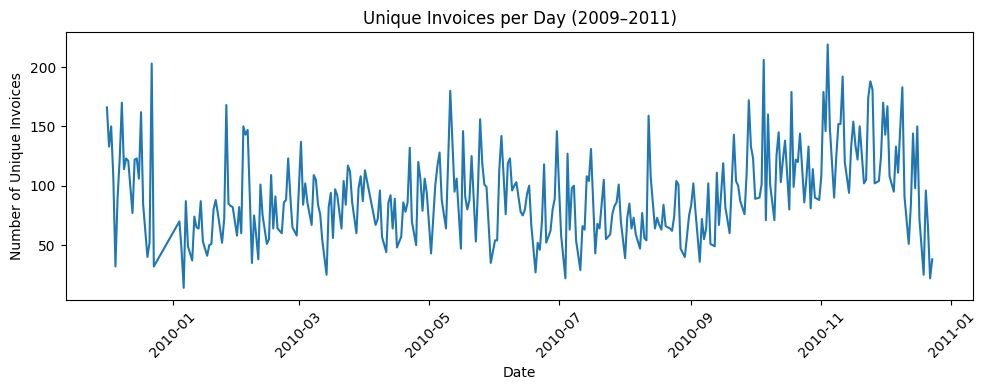

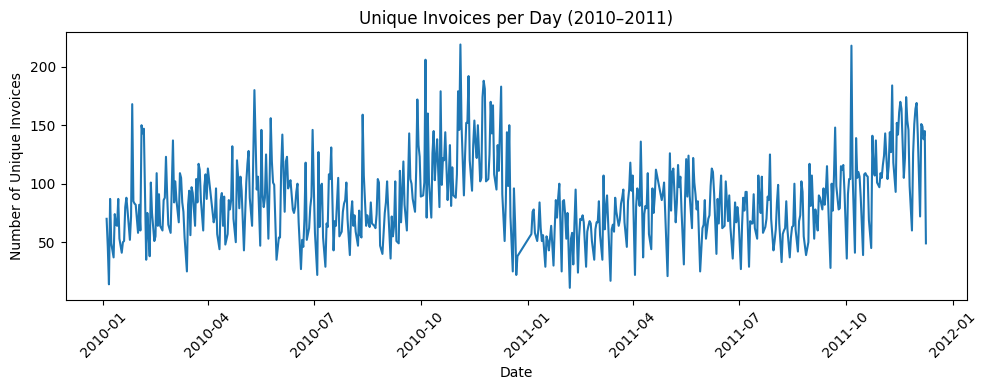

In [7]:
# Convert date_only column to datetime.date if not already
daily_unique["date_only"] = pd.to_datetime(daily_unique["date_only"])

# --- 1) Filter for 2009 to 2011
mask_2009_2010 = (
    (daily_unique["date_only"] >= "2009-01-01") &
    (daily_unique["date_only"] <= "2010-12-31")
)
daily_2009_2010 = daily_unique.loc[mask_2009_2010]

plt.figure(figsize=(10,4))
plt.plot(daily_2009_2010["date_only"], daily_2009_2010["unique_invoices"])
plt.title("Unique Invoices per Day (2009–2011)")
plt.xlabel("Date")
plt.ylabel("Number of Unique Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/eda_visualization/IT24100269_unique_invoices_2009_2010.png", dpi=150)
plt.show()


# --- 2) Filter for 2010 to 2011
mask_2010_2011 = (daily_unique["date_only"] >= "2010-01-01") & (daily_unique["date_only"] <= "2011-12-31")
daily_2010_2011 = daily_unique.loc[mask_2010_2011]

plt.figure(figsize=(10,4))
plt.plot(daily_2010_2011["date_only"], daily_2010_2011["unique_invoices"])
plt.title("Unique Invoices per Day (2010–2011)")
plt.xlabel("Date")
plt.ylabel("Number of Unique Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/eda_visualization/IT24100269_unique_invoices_2010_2011.png", dpi=150)
plt.show()